### 二手车交易价格预测--T3：特征工程
对二手车交易数据进行训练，预测其交易价格

**常见的特征工程包括：**

1. 异常处理：
    - 通过箱线图（或 3-Sigma）分析删除异常值；
    - BOX-COX 转换（处理有偏分布）；
    - 长尾截断；
2. 特征归一化/标准化：
    - 标准化（转换为标准正态分布）；
    - 归一化（抓换到[0,1]区间）；
    - 针对幂律分布，可以采用公式： 
3. 数据分桶：
    - 等频分桶；
    - 等距分桶；
    - Best-KS 分桶（类似利用基尼指数进行二分类）；
    - 卡方分桶；
4. 缺失值处理：
    - 不处理（针对类似XGBoost等树模型）；
    - 删除（缺失数据太多）；
    - 插值补全，包括均值/中位数/众数/建模预测/多重插补/压缩感知补全/矩阵补全等；
    - 分箱，缺失值一个箱；
5. 特征构造：
    - 构造统计量特征，报告计数、求和、比例、标准差等；
    - 时间特征，包括相对时间和绝对时间，节假日，双休日等；
    - 地理信息，包括分箱，分布编码等方法；
    - 非线性变换，包括 log/ 平方/ 根号等；
    - 特征组合，特征交叉；
6. 特征筛选
    - 过滤式（filter）：先对数据进行特征选择，然后再训练学习器，常见的方法有Relief/方差选择法/相关系数法/卡方检验法/互信息法；
    - 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper） ；
    - 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有 lasso 回归；
7. 降维
    - PCA/ LDA/ ICA；
    - 特征选择也是一种降维。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

import warnings
warnings.filterwarnings('ignore')

# 设置图表中文字属性，防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [2]:
# 读取数据
path = '../../dataset/user_car_data/'
train_data = pd.read_csv(path + 'used_car_train.csv', sep=' ')
test_data = pd.read_csv(path + 'used_car_testA.csv', sep=' ')

print('训练数据集的大小', train_data.shape)
print('测试数据集的大小', test_data.shape)

train_data.head()

训练数据集的大小 (150000, 31)
测试数据集的大小 (50000, 30)


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [11]:
# 删除异常值
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用box_plot(scale=3)进行清洗
    :param data: 接收pandas数据格式
    :param col_name: pandas列明
    :param scale: 尺度--3-sigma
    :return :
    """
    
    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收pandas.Series数据格式
        :param box_scale: 箱线图尺度
        :return:
        """
        
        # 四分位距
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        # 上下限值/上下边界值
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        # 异常值
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        
        # 返回上下边界, 异常值
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print('delete number is: {}'.format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print('now column number is: {}'.format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette='Set1', ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data, palette='Set1', ax=ax[1])
    return data_n

delete number is: 963
now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


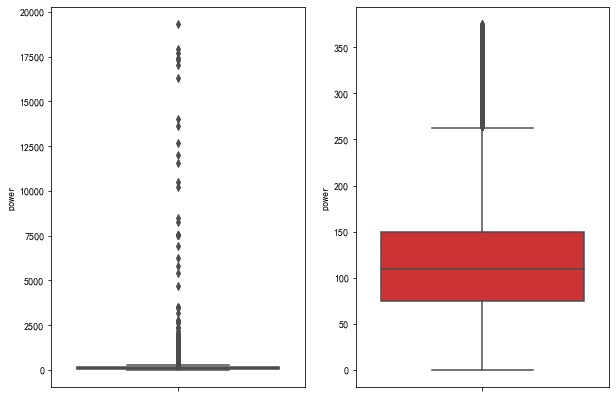

In [12]:
# 我们可以删掉一些异常数据，以 power 为例。 
train_data = outliers_proc(train_data, 'power', scale=3)

In [ ]:
# 特征构造

#### 总结
特征工程是比赛中最至关重要的的一块，特别是传统的比赛，大家的模型可能都差不多，调参带来的效果增幅是非常有限的，但特征工程的好坏往往会决定了最终的排名和成绩。

特征工程的主要目的还是在于将数据转换为能更好地表示潜在问题的特征，从而提高机器学习的性能。比如，异常值处理是为了去除噪声，填补缺失值可以加入先验知识等。

特征构造也属于特征工程的一部分，其目的是为了增强数据的表达。

有些比赛的特征是匿名特征，这导致我们并不清楚特征相互之间的关联性，这时我们就只有单纯基于特征进行处理，比如装箱，groupby，agg 等这样一些操作进行一些特征统计，此外还可以对特征进行进一步的 log，exp 等变换，或者对多个特征进行四则运算（如上面我们算出的使用时长），多项式组合等然后进行筛选。由于特征的匿名性其实限制了很多对于特征的处理，当然有些时候用 NN 去提取一些特征也会达到意想不到的良好效果。

对于知道特征含义（非匿名）的特征工程，特别是在工业类型比赛中，会基于信号处理，频域提取，峰度，偏度等构建更为有实际意义的特征，这就是结合背景的特征构建，在推荐系统中也是这样的，各种类型点击率统计，各时段统计，加用户属性的统计等等，这样一种特征构建往往要深入分析背后的业务逻辑或者说物理原理，从而才能更好的找到 magic。

当然特征工程其实是和模型结合在一起的，这就是为什么要为 LR NN 做分桶和特征归一化的原因，而对于特征的处理效果和特征重要性等往往要通过模型来验证。

总的来说，特征工程是一个入门简单，但想精通非常难的一件事。